# Feature Matching Demo

This notebook demonstrates image feature matching


## Setup

Import necessary libraries and load validation dataset:


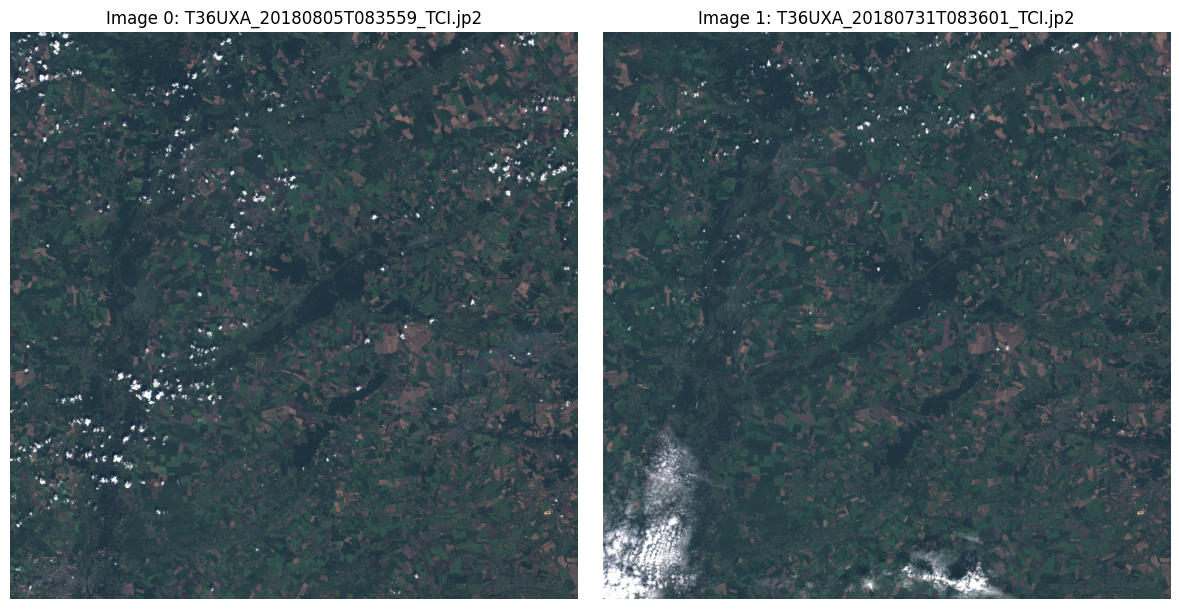

In [23]:
import matplotlib.pyplot as plt

from dataset.dataset import ImageDataset
from models.baseline_models.loftr import LoFTR
from models.baseline_models.lightglue import LightGlue


val_dataset = ImageDataset(root_dir="dataset/data/val")
sample0 = val_dataset[3]
sample1 = val_dataset[5]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(sample0['image_np'])
axes[0].set_title(f"Image 0: {sample0['filename']}")
axes[0].axis('off')

axes[1].imshow(sample1['image_np'])
axes[1].set_title(f"Image 1: {sample1['filename']}")
axes[1].axis('off')

plt.tight_layout()
plt.show()

## LoFTR Matching

Test feature matching using baseline LoFTR:


In [16]:
loftr = LoFTR()
loftr_matches = loftr(sample0['image'], sample1['image'], confidence_threshold=0.9)

print(f"LoFTR Results:")
print(f"Total keypoints (img0): {len(loftr_matches['keypoints0'])}")
print(f"Total keypoints (img1): {len(loftr_matches['keypoints1'])}")
print(f"Inliers: {loftr_matches['inliers'].sum()}")
print(f"Average confidence: {loftr_matches['confidence'].mean():.4f}")

LoFTR Results:
Total keypoints (img0): 20238
Total keypoints (img1): 20238
Inliers: 18793
Average confidence: 0.9949


Visualizing LoFTR matches...


<Figure size 1600x800 with 0 Axes>

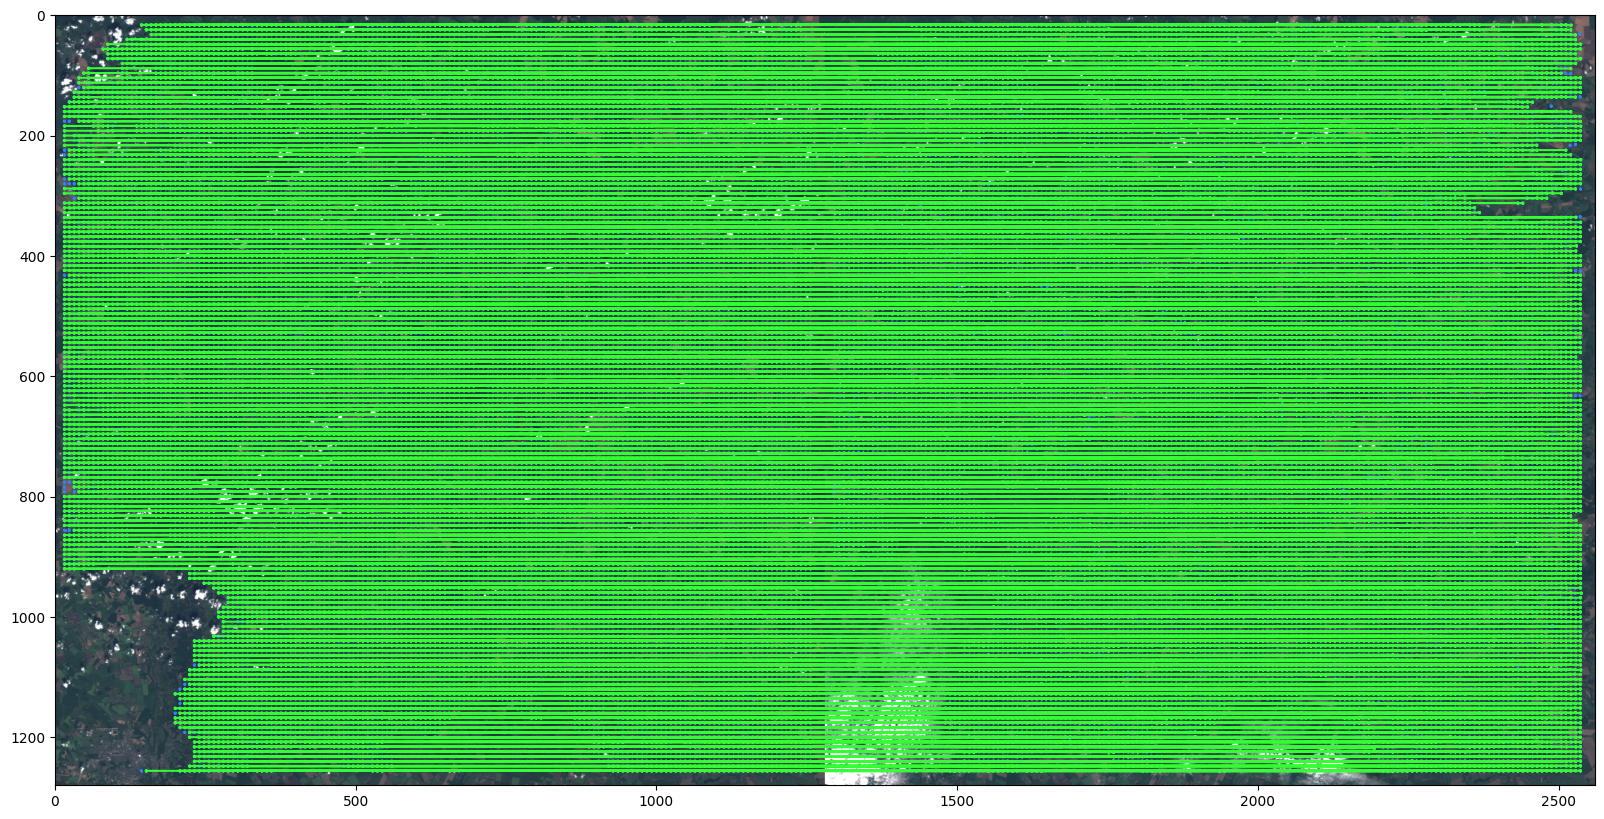

In [17]:
print("Visualizing LoFTR matches...")
plt.figure(figsize=(16, 8))
loftr.draw(loftr_matches)
plt.show()


## LightGlue Matching

Test feature matching using LightGlue with SuperPoint features:


In [11]:
lightglue = LightGlue()
lg_matches = lightglue(sample0['image'], sample1['image'], confidence_threshold=0.8)

print(f"LightGlue Results:")
print(f"Total keypoints (img0): {len(lg_matches['keypoints0'])}")
print(f"Total keypoints (img1): {len(lg_matches['keypoints1'])}")
print(f"Inliers: {lg_matches['inliers'].sum()}")
print(f"Average confidence: {lg_matches['confidence'].mean():.4f}")


Loaded LightGlue model
LightGlue Results:
Total keypoints (img0): 653
Total keypoints (img1): 653
Inliers: 646
Average confidence: 0.9807


Visualizing LightGlue matches...


<Figure size 1600x800 with 0 Axes>

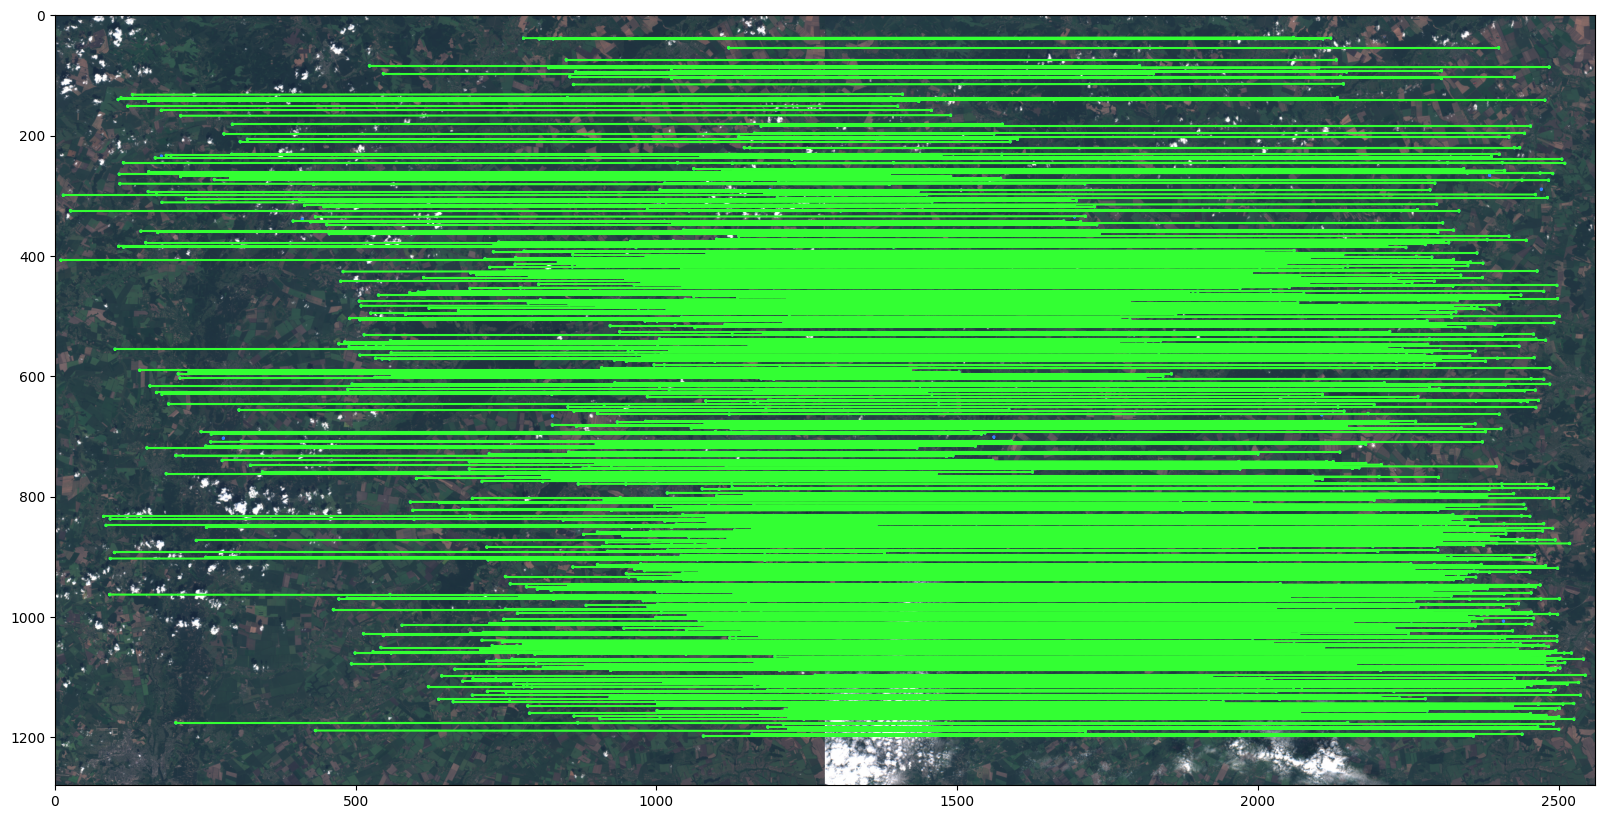

In [12]:
print("Visualizing LightGlue matches...")
plt.figure(figsize=(16, 8))
lightglue.draw(lg_matches)
plt.show()


## Comparison Summary

Compare the performance of both matchers:


In [13]:
print("Model Comparison:")
print("-" * 60)
print(f"{'Metric':<30} {'LoFTR':<15} {'LightGlue':<15}")
print("-" * 60)
print(f"{'Total Matches':<30} {len(loftr_matches['inliers']):<15} {len(lg_matches['inliers']):<15}")
print(f"{'Inliers':<30} {loftr_matches['inliers'].sum():<15} {lg_matches['inliers'].sum():<15}")
print(f"{'Inlier Rate (%)':<30} {loftr_matches['inliers'].sum()/len(loftr_matches['inliers'])*100:.2f}{'%':<10} {lg_matches['inliers'].sum()/len(lg_matches['inliers'])*100:.2f}{'%':<14}")
print(f"{'Avg Confidence':<30} {loftr_matches['confidence'].mean():.4f}{'':<9} {lg_matches['confidence'].mean():.4f}{'':<15}")
print("-" * 60)


Model Comparison:
------------------------------------------------------------
Metric                         LoFTR           LightGlue      
------------------------------------------------------------
Total Matches                  20238           653            
Inliers                        18793           646            
Inlier Rate (%)                92.86%          98.93%             
Avg Confidence                 0.9949          0.9807               
------------------------------------------------------------


## Base SuperPoint

Train SuperPoint by self-matching augmented views of the same image.


In [ ]:
from models.trainable.superpoint.train import SuperPointTrainer

train_dir = "dataset/data/train"
val_dir = None

trainer_sm = SuperPointTrainer(
    train_dir=train_dir,
    val_dir=val_dir,
    max_keypoints=512,
    learning_rate=1e-4,
)
trainer_sm.train(
    num_epochs=1,
    batch_size=2,
    save_dir="models/trainable/superpoint/superpoint_sm_checkpoints",
)

## SuperPoint Inference with LightGlue


Successfully loaded SuperPoint weights from models/trainable/superpoint/superpoint_sm_checkpoints/best_superpoint.pth


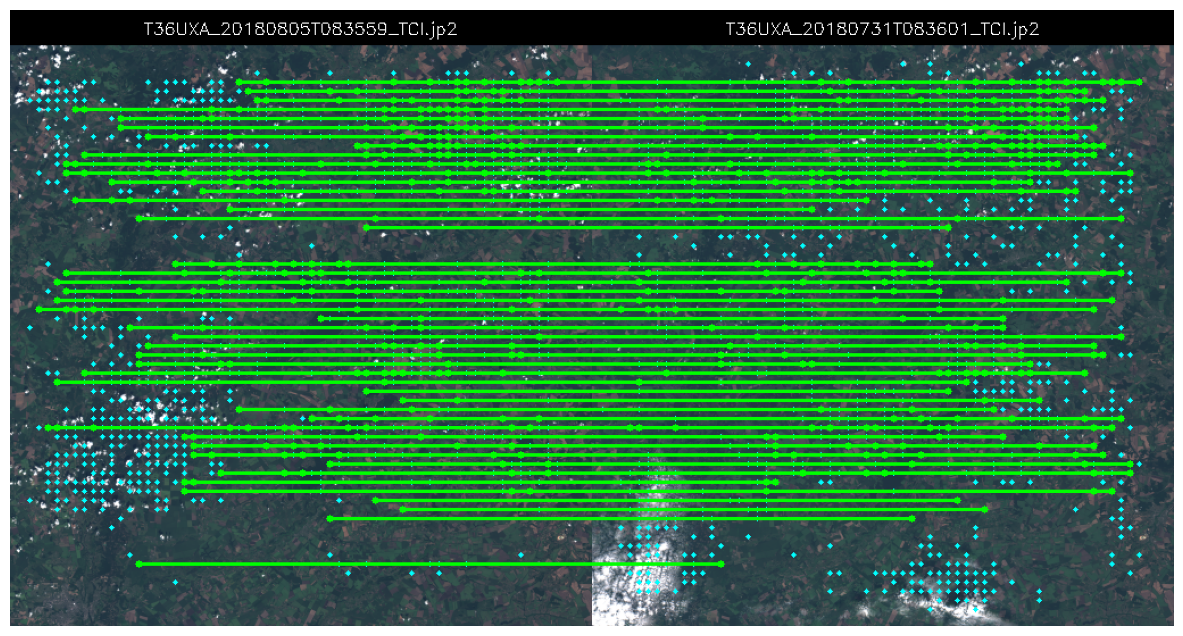

In [14]:
import matplotlib.pyplot as plt
from dataset.dataset import ImageDataset
from models.trainable.superpoint.inference import SuperPointLightGlueInference

sm_weights = "models/trainable/superpoint/superpoint_sm_checkpoints/best_superpoint.pth"
sp_lg_sm = SuperPointLightGlueInference(superpoint_weights=sm_weights, max_keypoints=1024)

inf_ds = ImageDataset(root_dir="dataset/data/val", target_size=(512, 512), device='cpu')

res_sm = sp_lg_sm.process_image_pair_from_dataset(inf_ds, idx0=3, idx1=5, confidence_threshold=0.5)
vis_sm = sp_lg_sm.draw_matches(res_sm, show_keypoints=True)

plt.figure(figsize=(16, 8))
plt.imshow(vis_sm)
plt.axis('off')
plt.show()

## PolygonSuperPoint

Train SuperPoint to detect polygon keypoints from geojson

In [ ]:
from models.trainable.superpoint.train_polygon import PolygonSuperPointTrainer

train_dir = "dataset/data/train"
val_dir = None
geojson_path = "dataset/data/base_dataset/deforestation_labels.geojson"

trainer_gt = PolygonSuperPointTrainer(
    train_dir=train_dir,
    val_dir=val_dir,
    geojson_path=geojson_path,
    max_keypoints=512,
    learning_rate=1e-4,
    proximity_threshold=5.0,
)
trainer_gt.train(
    num_epochs=1,
    batch_size=2,
    save_dir="models/trainable/superpoint/polygon_superpoint_checkpoints",
)


## PolygonSuperPoint — Inference with LightGlue

Successfully loaded SuperPoint weights from models/trainable/superpoint/polygon_superpoint_checkpoints/best_superpoint_gt.pth


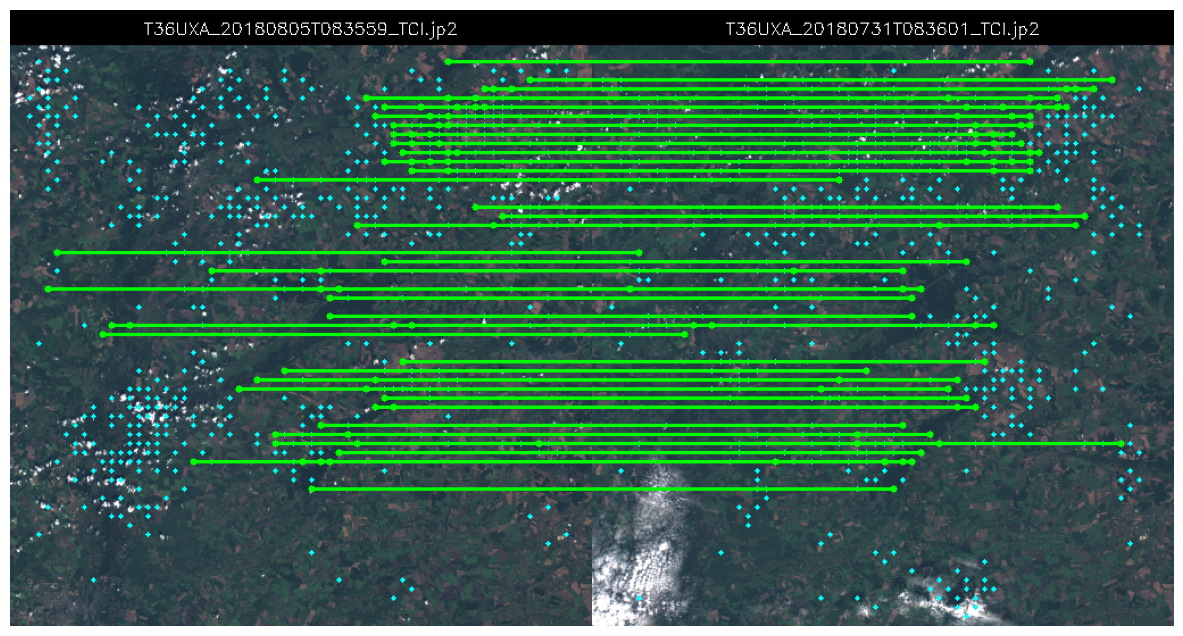

In [15]:
from models.trainable.superpoint.inference import SuperPointLightGlueInference

gt_weights = "models/trainable/superpoint/polygon_superpoint_checkpoints/best_superpoint_gt.pth"
sp_lg_gt = SuperPointLightGlueInference(superpoint_weights=gt_weights, max_keypoints=512)

inf_ds = ImageDataset(root_dir="dataset/data/val", target_size=(512, 512), device='cpu')

res_gt = sp_lg_gt.process_image_pair_from_dataset(inf_ds, idx0=3, idx1=5, confidence_threshold=0.5)
vis_gt = sp_lg_gt.draw_matches(res_gt, show_keypoints=True)

plt.figure(figsize=(16, 8))
plt.imshow(vis_gt)
plt.axis('off')
plt.show()
